In [33]:
import json
import os
import collections
import pandas as pd
from altair import *

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
files = os.listdir('user_data/')
covered = set()
count = 0
r1, r2, r3 = [], [], []
for name in files:
    if '.json' not in name: continue
    # print(name)
    count += 1
    with open('user_data/' + name, 'r') as f:
        d = json.load(f)
        for item in d:
            if 'rank_result' in item:
                covered.add(item['rank_result'][0].split('/')[1].split('_')[0])
                t = [i.split('/')[0] for i in item['rank_result']]
                r1.append(t[0])
                r2.append(t[1])
                r3.append(t[2])
print('number of subjects:', count)
print('number of covered images:', len(covered))
print('coverage rate:', len(covered) / 3000)

number of subjects: 26
number of covered images: 1794
coverage rate: 0.598


In [6]:
r1 = collections.Counter(r1)
r2 = collections.Counter(r2)
r3 = collections.Counter(r3)

In [68]:
total = sum(r1[k] for k in r1)

In [25]:
plot_data = []
for k in dict(r1):
    plot_data.append({
        'rank': 1,
        'method': k,
        'count': dict(r1)[k]
    })

for k in dict(r2):
    plot_data.append({
        'rank': 2,
        'method': k,
        'count': dict(r2)[k]
    })

for k in dict(r3):
    plot_data.append({
        'rank': 3,
        'method': k,
        'count': dict(r3)[k]
    })

In [70]:
df = pd.DataFrame(plot_data)
df['percentage'] = df['count'].apply(lambda x: x / total)

In [71]:
df

,count,method,rank,percentage
0,2158,ours,1,0.830000
1,208,gl,1,0.080000
2,234,ce,1,0.090000
3,1361,ce,2,0.523462
4,936,gl,2,0.360000
5,303,ours,2,0.116538
6,1456,gl,3,0.560000
7,1005,ce,3,0.386538
8,139,ours,3,0.053462


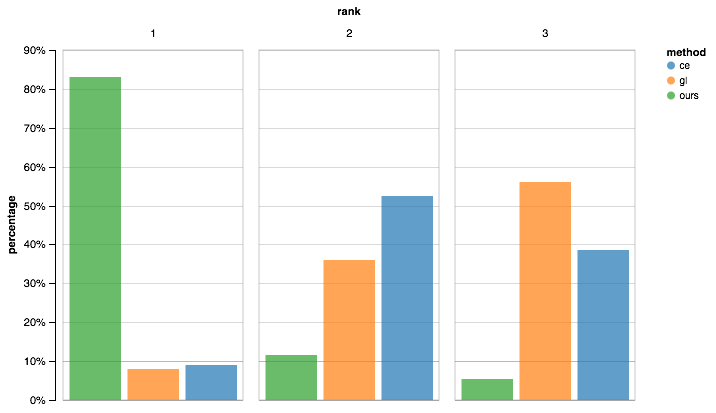

In [83]:
Chart(df, width=180).mark_bar().encode(
    color=Color('method:N'),
    column='rank:N',
    x=X('method:N',
        sort='descending',
        scale=Scale(bandSize=17.0),
        axis=False),
    y=Y('percentage:Q',
       axis=Axis(title='percentage', format='.00%')),
    legend=Legend()
)